In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
set_config(display='diagram') 
import numpy as np

## Khám phá dữ liệu


In [2]:
data_df = pd.read_csv('total_data.csv', index_col=0)
data_df.head()

,Level,PM2.5,PM10,O3,NO2,SO2,CO,City
0,Very Unhealthy,227.5,NaN,NaN,NaN,NaN,NaN,NaN
1,Very Unhealthy,137.7,201.2,9.8,35.0,12.6,1181.7,NaN
2,Very Unhealthy,157.4,2.2,NaN,NaN,NaN,NaN,NaN
3,Unhealthy,112.2,198.5,14.8,NaN,NaN,NaN,NaN
4,Unhealthy,104.5,NaN,NaN,NaN,NaN,NaN,NaN


**Dữ liệu có bao nhiêu dòng và bao nhiêu cột**

In [3]:
data_df.shape

(1443, 8)

**Kiểm tra xem có các dòng có dữ liệu trùng nhau hay không**

In [4]:
data_df.duplicated().sum()

399

**Loại bỏ những dòng có dữ liệu trùng nhau**

In [5]:
data_df = data_df.drop_duplicates()
data_df.shape

(1044, 8)

**Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?**

Mỗi dòng là dữ liệu chất lượng không khí của một địa điểm tại một thời điểm nhất định

**Ý nghĩa của các cột trong dataframe**

| Tên cột | Ý nghĩa | Đơn vị |
| :-: | :-: | :-: |
| City | Tên thành phố hoặc địa điểm |  |
| Level | Cấp độ chất lượng không khí |  |
| PM2.5 | Mật độ các hạt bụi có kích thước đường kính nhỏ hơn hoặc bằng 2.5 µm trong không khí| µg/m³ |
| PM10 | Mật độ các hạt bụi có kích thước đường kính từ 2.5 tới 10 µm trong không khí| µg/m³ |
| O3 | Mật độ O3 trong không khí| µg/m³ |
| NO2 | Mật độ NO2 trong không khí| µg/m³ |
| SO2 | Mật độ SO2 trong không khí| µg/m³ |
| CO | Mật độ CO trong không khí| µg/m³ |

## Đưa ra câu hỏi cần trả lời

Dựa vào ý nghĩa các cột và việc tìm hiểu chủ đề đánh giá chất lượng không khí, ta xác định cột ouput là cột Level. Nhiệm vụ của đồ án này sẽ là tiến hành dự đoán cấp độ không khí. Cấp độ chất lượng không khí được suy ra từ các input là mật độ PM2.5, PM10 và các khí O3, NO2, SO2, CO. Cột City sẽ được loại bỏ khỏi input vì nó không ảnh hưởng đến kết quả output được suy ra.

In [6]:
#xóa cột City vì là cột định danh không cần thiết cho mô hình
data_df = data_df.drop(columns=['City'])

**Kiểu dữ liệu của output**

Ta thấy output có dạng categories.

In [7]:
data_df['Level'].dtype

dtype('O')

**Kiểm tra xem có giá trị thiếu trong cột output hay không, nếu có thì loại bỏ các dòng có cột output là giá trị thiếu.**

In [8]:
data_df['Level'].isna().sum()

3

In [9]:
data_df = data_df[data_df['Level'].notna()]
data_df['Level'].isna().sum()

0

**Xem các giá trị xuất hiện trong cột output**


Ta thấy có 6 cấp độ chất lượng không khí.

| Cấp độ | Khoảng giá trị AQI | Mức độ cảnh báo y tế | Số hóa tương ứng |
| :-: | :-: | :-: | :-: |
| Good | 0 - 50 | Không ảnh hưởng đến sức khỏe | 0 |
| Moderate | 51 - 100 | Ở mức chấp nhận được. Nhóm nhạy cảm nên hạn chế thời gian ra ngoài | 1 |
| Unhealthy For Sensitive Groups | 101 - 150 | Nhóm người nhạy cảm có thể bị ảnh hưởng đến sức khỏe. Phần lớn người dân không có nguy cơ bị ảnh hưởng đến sức khỏe | 2 |
| Unhealthy | 151 - 200 | Tất cả mọi người có thể bắt đầu bị ảnh hưởng sức khỏe. Những nhóm người bị nhạy cảm có thể bị ảnh hưởng đến sức khỏe nghiêm trọng hơn | 3 |
| Very unhealthy | 201 - 300 | Cảnh báo nguy hại sức khỏe nghiêm trọng. Đa số mọi người đều bị ảnh hưởng | 4 |
| Hazardous | 300+ | Cảnh báo sức khỏe: tất cả mọi người có thể bị ảnh hưởng đến sức khỏe một cách nghiêm trọng | 5 |

Giải thích về chỉ số AQI: chỉ số AQI là chỉ số đo chất lượng không khí được tính từ mật độ PM2.5, PM10, O3, NO2, SO2, CO. Từ chỉ số này, người ta chia ra thành 6 thang đo như ở trên. 

Trong đề tài đồ án, vì nhận thấy rằng cách tính chỉ số AQI rất phức tạp và khác nhau ở nhiều quốc gia, bên cạnh đó, mục đích cuối cùng của việc tính chỉ số AQI cũng là để quy về mức độ của chất lượng không khí như thang đo ở trên. Do đó thay vì tính toán chỉ số AQI, ta trực tiếp suy ra mức độ chất lượng không khí từ mật độ các khí.


In [10]:
temp = data_df['Level'].value_counts(normalize=True) * 100
temp

Moderate                          37.560038
Good                              25.552354
Unhealthy For Sensitive Groups    14.409222
Unhealthy                         13.544669
Very Unhealthy                     5.091258
Hazardous                          3.842459
Name: Level, dtype: float64

**Số hóa output**

Để dễ nhìn, nhóm tiến hành số hóa các cấp độ chất lượng không khí tương ứng từ 0 - 5 như ở bảng trên.

In [11]:
def transform_y(train_y_sr):
    new_y = []
    for index, value in train_y_sr.items():
        if value == 'Good':
            new_y.append(0)
        elif value == 'Moderate':
            new_y.append(1)
        elif value =='Unhealthy For Sensitive Groups':
            new_y.append(2)
        elif value == 'Unhealthy':
            new_y.append(3)
        elif value == 'Very Unhealthy':
            new_y.append(4)
        else:
            new_y.append(5)
    new_y_sr = pd.Series(new_y)
    return new_y_sr

## Tiền xử lý (tách các tập)

**Đầu tiên, tách output ra khỏi dataframe**

In [12]:
# Tách X và y
y_sr = data_df["Level"]
X_df = data_df.drop("Level", axis=1)


**Trực quan hóa cột output**

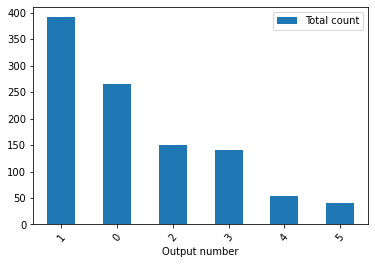

In [13]:
y_sr = transform_y(data_df['Level'])
data_plot = dict()
indexes = []
values = []
for i, v in y_sr.value_counts().items():
    indexes.append(i)
    values.append(v)
data_plot['Output number'] = indexes
data_plot['Total count'] = values

df_plot = pd.DataFrame(data = data_plot)
df_plot.plot.bar(x='Output number', y='Total count', rot=50)

In [14]:
X_df

,PM2.5,PM10,O3,NO2,SO2,CO
0,227.5,NaN,NaN,NaN,NaN,NaN
1,137.7,201.2,9.8,35.0,12.6,1181.7
2,157.4,2.2,NaN,NaN,NaN,NaN
3,112.2,198.5,14.8,NaN,NaN,NaN
4,104.5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1094,53.0,67.0,3.0,34.0,1.0,0.0
1095,47.0,70.0,2.0,60.0,2.0,NaN
1096,46.0,67.2,4.0,34.0,3.0,0.0
1097,16.0,NaN,NaN,NaN,NaN,NaN


**Tách tập X_df thành tập train, test và validation**

Đầu tiên, tách X_df thành 2 tập trainval và test theo tỉ lệ 70%:30% 
Sau đó, tách trainval thành 2 tập train và validation theo tỉ lệ 70%:30%

In [15]:
trainval_X_df, test_X_df, trainval_y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.3, random_state=None, stratify = y_sr)
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(trainval_X_df, trainval_y_sr, test_size=0.3, random_state=None, stratify = trainval_y_sr)

## Khám phá dữ liệu (tập huấn luyện)

In [16]:
train_X_df.shape

(509, 6)

In [17]:
train_y_sr.shape

(509,)

In [18]:
train_X_df.index

Int64Index([ 465,  767,  658,  942,  159, 1066,  441,  893,  520, 1006,
            ...
             552,  651,  972,  450,  890,  312,  311,  263,  532,    1],
           dtype='int64', length=509)

**Mỗi cột input trong hiện đang có dữ liệu gì? Kiểm tra xem có cột nào có kiểu dữ liệu chưa phù hợp hay không**

Ta thấy tất cả các cột đều có dạng số phù hợp để huấn luyện.

In [19]:
train_X_df.dtypes

PM2.5    float64
PM10     float64
O3       float64
NO2      float64
SO2      float64
CO       float64
dtype: object

In [20]:
train_y_sr.value_counts()

1    191
0    130
2     73
3     69
4     26
5     20
dtype: int64

**Phân bố của các cột**

In [21]:
num_cols = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']
df = train_X_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])


,PM2.5,PM10,O3,NO2,SO2,CO
missing_ratio,1.4,39.7,66.6,51.7,65.8,80.9
min,0.0,0.0,0.0,0.0,0.0,0.0
lower_quartile,12.0,12.5,4.6,11.4,2.0,57.3
median,25.0,25.1,15.2,26.0,5.0,510.0
upper_quartile,53.3,66.5,38.0,44.2,12.9,1153.1
max,770.0,1159.0,116.0,470.0,134.0,4650.0


## Tiền xử lý (tập huấn luyện)

Thay các giá trị NaN bằng 0.0. 
Ta không thay giá trị NaN bằng mean hay median như thông thường vì công thức tính chỉ số AQI không yêu cầu phải có đầy đủ tất cả các giá trị mật độ của các khí, nghĩa là giá trị mật độ của khí nào thiếu sẽ được xem như không có, do đó ta thay những giá trị NaN bằng 0.0

(Mặc dù chủ đề đồ án không tính chỉ số AQI, nhưng chỉ số này tương ứng với mức độ chất lượng không khí - output mà ta cần suy ra)

In [22]:
#hàm tiền xử lý
def fill_missing(X_df):
    num_cols = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']
    df = X_df.copy()
    #thay 'nan' bằng 0.0
    df[num_cols] = X_df[num_cols].fillna(0)
    return df

In [23]:
#sử dụng FunctionTransformer để transform tập dữ liệu
transform = FunctionTransformer(fill_missing)


**Tạo pipeline tiền xử lý**

Trong pipeline có thêm bước tiền xử lý là StandardScaler() để chuẩn hóa dữ liệu của các cột input.
Sau đó, gọi fit_transform.

In [24]:
preprocess_pipeline = make_pipeline(FunctionTransformer(fill_missing), StandardScaler())

In [25]:
preprocess_pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function fill_missing at 0x0000024D242D3280>)),
                ('standardscaler', StandardScaler())])

In [26]:
#preprocess tập train
preprocess_train_X = preprocess_pipeline.fit_transform(train_X_df)
preprocess_train_X

array([[ 0.74706675, -0.41296175, -0.47939611, -0.47732642, -0.34399242,
        -0.29563553],
       [-0.00862317, -0.41296175, -0.47939611, -0.47732642, -0.34399242,
        -0.29563553],
       [-0.59544384, -0.41296175,  1.738382  , -0.19949053, -0.34399242,
        -0.29563553],
       ...,
       [-0.13105338, -0.41296175, -0.47939611, -0.47732642, -0.34399242,
        -0.29563553],
       [-0.04661875, -0.13942831, -0.47939611, -0.47732642, -0.34399242,
        -0.29563553],
       [ 1.24382382,  1.37970694,  0.14158176,  0.49509918,  0.78714017,
         1.85667725]])

## Tiền xử lý (tập validation)

Dùng phương thức transform để tiền xử lý cho các vector input mới trong tập validation.

In [27]:
val_X_df.shape

(219, 6)

In [28]:
val_y_sr

902    1
909    3
779    0
257    2
569    1
      ..
624    0
450    3
419    3
209    1
688    2
Length: 219, dtype: int64

In [29]:
preprocessed_val_X = preprocess_pipeline.transform(val_X_df)
preprocessed_val_X.shape

(219, 6)

## Tiền xử lý + Mô hình hóa

In [30]:
#neural_net = MLPClassifier(hidden_layer_sizes=(20,), activation='tanh', solver='lbfgs', max_iter=2500, random_state = 0)
neural_net = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=2500, random_state = 0)
full_pipeline = make_pipeline(preprocess_pipeline, neural_net)

In [31]:
full_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function fill_missing at 0x0000024D242D3280>)),
                                 ('standardscaler', StandardScaler())])),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', max_iter=2500, random_state=0,
                               solver='lbfgs'))])

**Tìm mô hình tốt nhất**

Thay đổi giá trị alpha và giá trị hidden_layer_size.Lưu các độ lỗi của tập train và validation vào mảng train_errs và val_errs. Tìm giá trị best_val_err là giá trị nhỏ nhất trong tập val_errs và lưu giá trị alpha, hidden_layer_size tương ứng vào 2 biến best_alpha và best_hidden_layer_size.

Có 8 giá trị alpha và 6 giá trị hidden_layer_sizes, như vậy ta sẽ tiến hành thử nghiệm trên 8 x 6 = 48 mô hình.

In [32]:
train_errs = []
val_errs = []
alphas = [0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
best_val_err = float('inf'); 
best_alpha = None;
li_hidden_layer_sizes = [5, 10, 15, 20, 25, 30]
best_hidden_layer_size = None
li = []

for alpha in alphas:
    for x in li_hidden_layer_sizes:
        full_pipeline.set_params(mlpclassifier__alpha=alpha, mlpclassifier__hidden_layer_sizes=x)
        full_pipeline.fit(train_X_df, train_y_sr)
        train_err = (1-full_pipeline.score(train_X_df, train_y_sr))*100
        train_errs.append(train_err)
        val_err = (1-full_pipeline.score(val_X_df, val_y_sr))*100
        val_errs.append(val_err)
        li.append([alpha, x])
    
best_val_err = min(val_errs)
best_alpha = li[val_errs.index(best_val_err)][0]
best_hidden_layer_size = li[val_errs.index(best_val_err)][1]
'Finish!'

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


'Finish!'

In [33]:
best_alpha

0.1

In [34]:
best_hidden_layer_size

30

**Trực quan hóa kết quả**

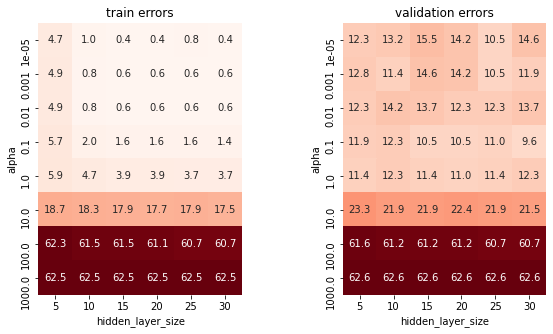

In [35]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=li_hidden_layer_sizes)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=li_hidden_layer_sizes)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('hidden_layer_size'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('hidden_layer_size'); plt.ylabel('alpha');

**Huấn luyện bằng mô hình tốt nhất tìm được**

In [36]:
full_pipeline.set_params(mlpclassifier__alpha=best_alpha, mlpclassifier__hidden_layer_sizes=best_hidden_layer_size)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function fill_missing at 0x0000024D242D3280>)),
                                 ('standardscaler', StandardScaler())])),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=0.1,
                               hidden_layer_sizes=30, max_iter=2500,
                               random_state=0, solver='lbfgs'))])

In [37]:
full_pipeline.fit(train_X_df, train_y_sr)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function fill_missing at 0x0000024D242D3280>)),
                                 ('standardscaler', StandardScaler())])),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=0.1,
                               hidden_layer_sizes=30, max_iter=2500,
                               random_state=0, solver='lbfgs'))])

## Đánh giá mô hình

**Tiến hành dự đoán output**

In [38]:
pred_y = full_pipeline.predict(test_X_df)

**Output kỳ vọng và output dự đoán được**

In [39]:
print(test_y_sr)

360    1
957    1
171    0
328    1
213    2
      ..
510    0
731    4
950    0
791    0
172    0
Length: 313, dtype: int64


In [40]:
print(pred_y)

[1 1 0 0 2 1 1 0 0 2 1 4 3 0 3 0 1 1 2 0 1 1 1 1 1 1 1 0 4 1 5 1 2 3 5 3 2
 3 1 1 1 1 1 3 0 2 0 0 2 0 1 0 0 3 0 1 1 0 1 1 4 0 0 1 4 2 1 5 1 0 2 1 1 1
 2 1 1 3 1 5 1 1 3 4 3 1 2 2 4 1 0 1 3 1 2 3 3 2 2 0 1 1 1 2 3 5 2 0 2 3 1
 1 0 1 3 0 3 2 2 0 1 1 3 1 1 2 2 4 1 1 0 4 0 0 1 0 0 2 1 1 0 3 1 1 1 3 0 4
 0 5 1 1 0 0 0 1 1 1 0 1 1 1 3 1 1 1 1 0 1 1 1 3 2 1 1 0 1 3 1 2 1 1 2 3 1
 2 4 1 2 5 1 5 3 1 2 0 3 1 1 0 0 1 2 0 1 3 0 3 1 1 0 2 2 0 0 2 3 0 0 0 3 2
 1 0 0 0 1 0 0 1 1 1 3 1 1 0 0 1 5 1 5 3 1 2 0 0 4 1 2 3 4 1 5 1 1 2 1 1 1
 2 0 3 3 3 1 4 5 0 0 0 3 1 0 1 1 1 0 0 1 1 5 1 2 1 0 1 0 0 1 0 3 2 4 2 2 1
 1 0 1 3 1 4 3 0 3 0 3 2 0 5 1 0 0]


**Độ chính xác**

In [41]:
full_pipeline.score(test_X_df, test_y_sr)*100

92.33226837060703

**Độ lỗi trên tập test**

In [42]:
(1 - full_pipeline.score(test_X_df, test_y_sr))*100

7.667731629392971